# Replicación Artículo: Comparative Analysis os Machine Learning Algorithms for Solar Irradiance Forecasting in Smart Grids

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
datos = pd.read_excel("02.Generación Pearson.xlsx")
datos.head(4)

,Fecha,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa
0,2022-09-01 00:00:00,0.0,0.0,19,24,15,98,4,77
1,2022-09-01 01:00:00,0.0,0.0,19,1,16,82,4,82
2,2022-09-01 02:00:00,0.0,0.0,18,2,16,73,3,85
3,2022-09-01 03:00:00,0.0,0.0,18,3,16,63,3,87


In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18290 entries, 0 to 18289
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             18290 non-null  datetime64[ns]
 1   Generación        18290 non-null  float64       
 2   Índice UV         18290 non-null  float64       
 3   Temperatura       18290 non-null  int64         
 4   Hora              18290 non-null  int64         
 5   DPT               18290 non-null  int64         
 6   Cobertura Nubes   18290 non-null  int64         
 7   Condición Cielo   18290 non-null  int64         
 8   Humedad Relativa  18290 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 1.3 MB


In [4]:
datos_sinfecha = datos.drop(["Fecha"], axis=1)

In [5]:
datos_sinfecha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18290 entries, 0 to 18289
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Generación        18290 non-null  float64
 1   Índice UV         18290 non-null  float64
 2   Temperatura       18290 non-null  int64  
 3   Hora              18290 non-null  int64  
 4   DPT               18290 non-null  int64  
 5   Cobertura Nubes   18290 non-null  int64  
 6   Condición Cielo   18290 non-null  int64  
 7   Humedad Relativa  18290 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 1.1 MB


In [6]:
datos_sinfecha.describe().T

,count,mean,std,min,25%,50%,75%,max
Generación,18290.0,9392.470410,11398.664257,0.0,0.0,532.0,21829.75,30000.0
Índice UV,18290.0,1.976309,3.181351,0.0,0.0,0.0,3.00,14.0
Temperatura,18290.0,19.456698,6.636539,0.0,15.0,19.0,24.00,39.0
Hora,18290.0,12.501312,6.923137,1.0,7.0,13.0,19.00,25.0
DPT,18290.0,9.838163,4.803726,0.0,6.0,10.0,14.00,20.0
Cobertura Nubes,18290.0,50.308201,37.865105,0.0,12.0,48.0,92.00,100.0
Condición Cielo,18290.0,2.675888,1.493505,1.0,1.0,3.0,4.00,5.0
Humedad Relativa,18290.0,58.879224,26.112205,3.0,37.0,62.0,83.00,100.0


In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
def decompose_generacion(df, share_type='ount', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

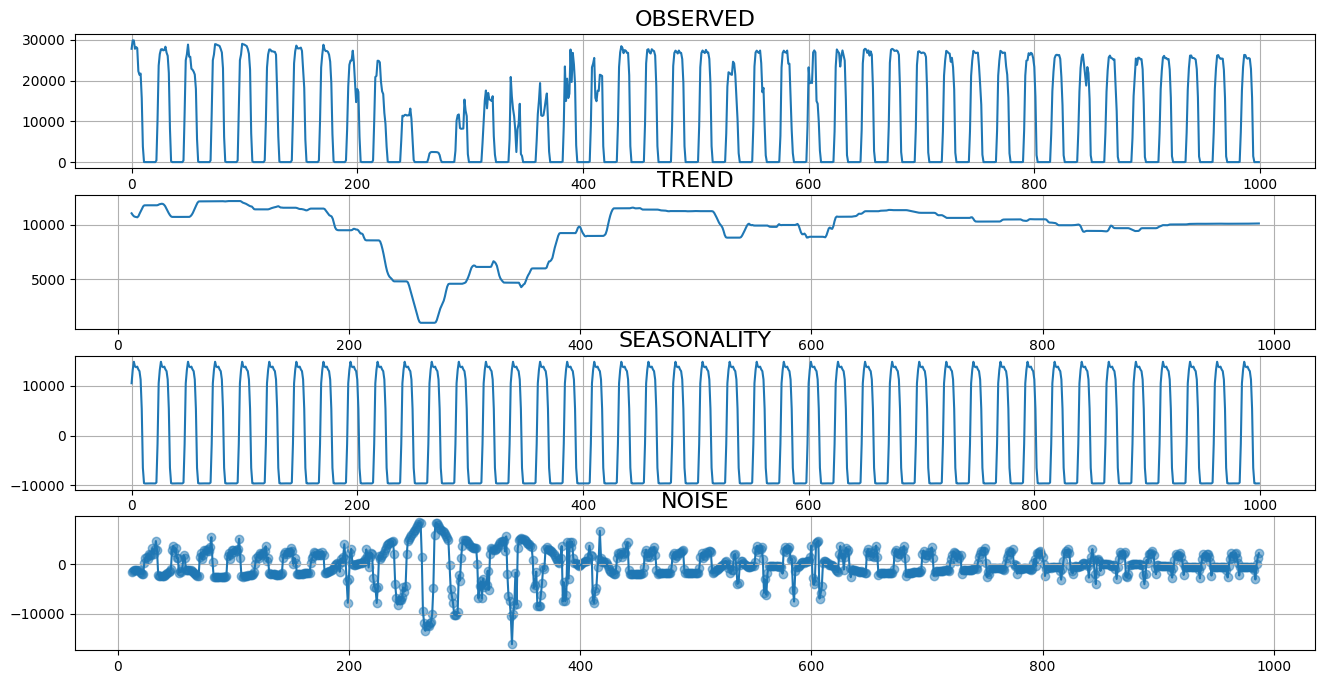

In [8]:
decompose_generacion(datos_sinfecha, share_type="Generación", samples=1000, period = 24)

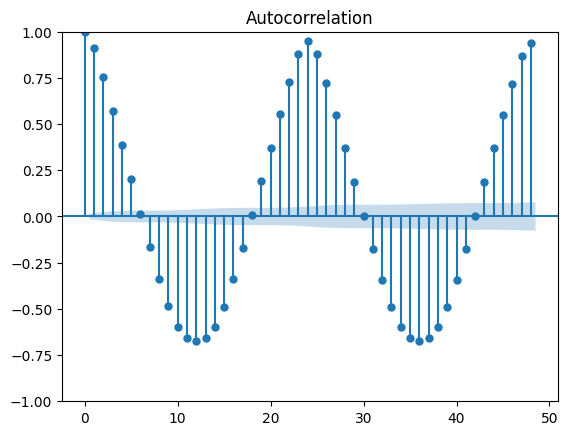

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(datos_sinfecha["Generación"].values, lags=48)
plt.show()

In [10]:
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error as mean_absolute_error
from sklearn.metrics import mean_squared_error as mean_squared_error
from sklearn.metrics import r2_score as r2_score
import seaborn as sns

In [11]:
def train_time_series_with_folds(df, model, horizon=24*10):
    X = df.drop('Generación', axis=1)
    #X = df[['Anio', 'NumDiaAnio', 'Temperatura', 'CodCondCielo', 'CodDirViento', 'IndiceUV', 'NumDia', 
   # 'NumHora', 'ProbabilidadLluvia', 'DPT', 'CoberturaNubes']]
    y = df['Generación']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    predictions = np.clip(predictions, 0, 30000)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)
    mape = np.round(mean_absolute_percentage_error(y_test, predictions), 3)    
    r2 = np.round(r2_score(y_test, predictions), 3)    
    rmse = np.round(np.sqrt(mean_squared_error(y_test, predictions)), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae} - MAPE {mape} - R2 {r2} - RMSE {rmse}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Generacion', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 18266, number of used features: 7
[LightGBM] [Info] Start training from score 9391.502891


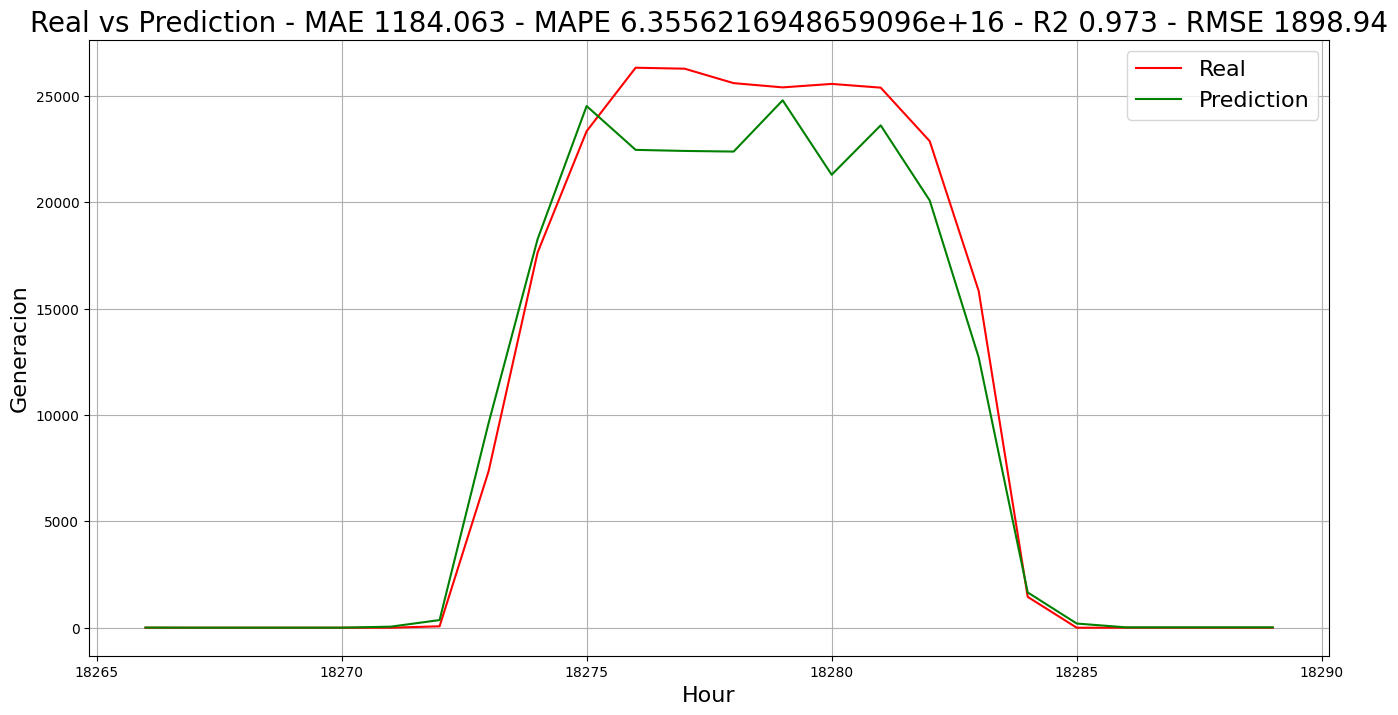

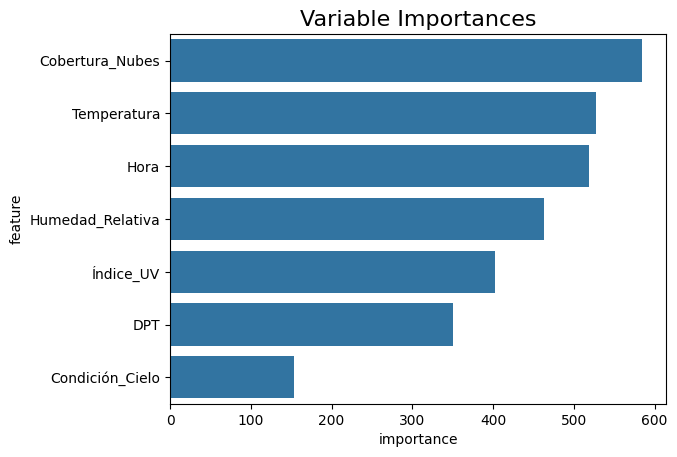

In [12]:
train_time_series_with_folds(datos_sinfecha, LGBMRegressor(), 24)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 18265, number of used features: 8
[LightGBM] [Info] Start training from score 9392.017071


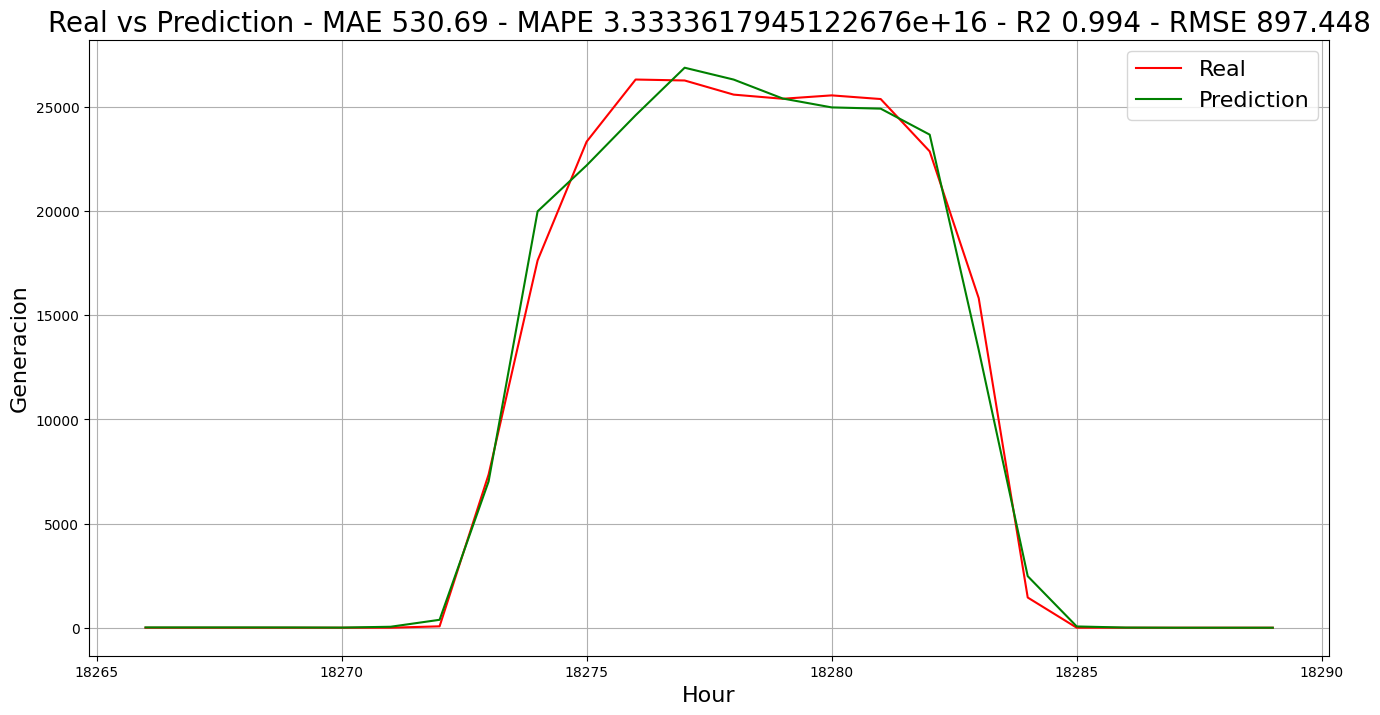

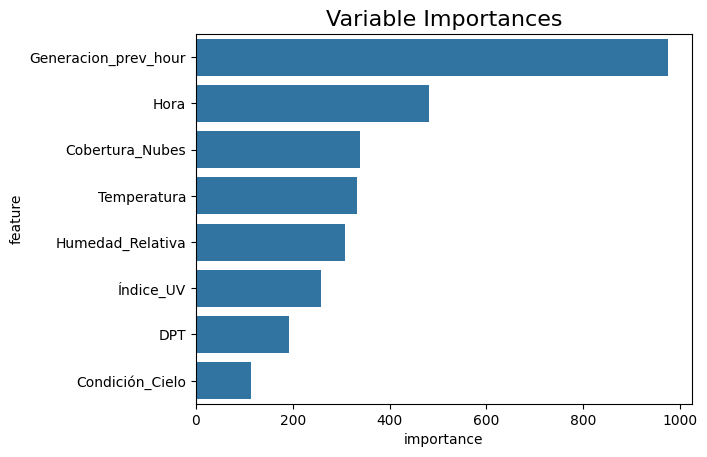

In [13]:
datos_2 = datos_sinfecha.copy()
datos_2["Generacion_prev_hour"] = datos_2["Generación"].shift(1)
datos_dropna = datos_2.dropna(how="any", axis= 0)
train_time_series_with_folds(datos_dropna, LGBMRegressor(), 24)

In [14]:
from timeit import default_timer as timer

In [15]:
X = datos_dropna.drop('Generación', axis=1)
y = datos_dropna['Generación']

In [16]:
#Porcentaje de entrenamiento
porcentaje = 0.8

#Horizonte de predicción
horizon = 1

In [17]:
#División de datos
lentrain100 = int(len(y) * porcentaje)
lentrain100

14631

In [18]:
#Dividimos 80/20
X_train, X_test = X.iloc[:lentrain100, :], X.iloc[lentrain100:, :]
y_train, y_test = y.iloc[:lentrain100], y.iloc[lentrain100:]

In [19]:
# Inicializar listas para métricas
mae_list, rmse_list, r2_list = [], [], []
resultados = pd.DataFrame(columns=['Hora', 'Real', 'Predicho'])

In [20]:
#Modelo LightGBM
model = LGBMRegressor(num_leaves=500, subsample= 0.10698460631792395, colsample_bytree= 0.7272836809565294, min_data_in_leaf= 85)

In [21]:
#Entrenamos en el 80% de los datos
start = timer()
model.fit(X_train, y_train)
end = timer()
print(f"Tiempo de entrenamiento: {end - start:.4f} segundos.")

[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 14631, number of used features: 8
[LightGBM] [Info] Start training from score 9081.481635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [22]:
#Evaluar en cada segmento de 1 día dentro del 20% de los datos
num_pruebas = len(X_test) // horizon
num_pruebas

3658

In [23]:
X_test

,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour
14632,8.0,35,15,4,0,1,8,27978.0
14633,5.0,36,16,3,0,1,8,27794.0
14634,3.0,37,17,3,4,1,8,24296.0
14635,2.0,36,18,2,9,1,9,23086.0
14636,1.0,35,19,1,13,1,10,17247.0
...,...,...,...,...,...,...,...,...
18285,0.0,22,20,9,2,1,45,1450.0
18286,0.0,20,21,10,1,1,54,0.0
18287,0.0,18,22,11,0,1,62,0.0
18288,0.0,17,23,11,0,1,69,0.0


In [24]:
# Inicializar listas para métricas
resultados = pd.DataFrame(columns=['Hora', 'Real', 'Predicho'])
#Ciclo diario de predicción
for i in range(num_pruebas):
    inicio = i * horizon
    fin = inicio + horizon

    X_test_seg = X_test.iloc[inicio:fin, :]
    y_test_seg = y_test.iloc[inicio:fin]

    if len(X_test_seg) < horizon:
        break

    y_pred = model.predict(X_test_seg)
    y_pred = np.clip(y_pred, 0, 30000)  # 🔹 Limitamos entre 0 y 30,000

    df_temp = pd.DataFrame({
        'Hora': X_test_seg.index,
        'Real': y_test_seg,
        'Predicho': y_pred
    })

    resultados = pd.concat([resultados, df_temp], ignore_index=True)

[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min

In [25]:
print(f"MAE: {mean_absolute_error(resultados['Real'], resultados['Predicho']):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(resultados['Real'], resultados['Predicho'])):.4f}")
print(f"R²: {r2_score(resultados['Real'], resultados['Predicho']):.4f}")

MAE: 953.1371
RMSE: 2023.1151
R²: 0.9705


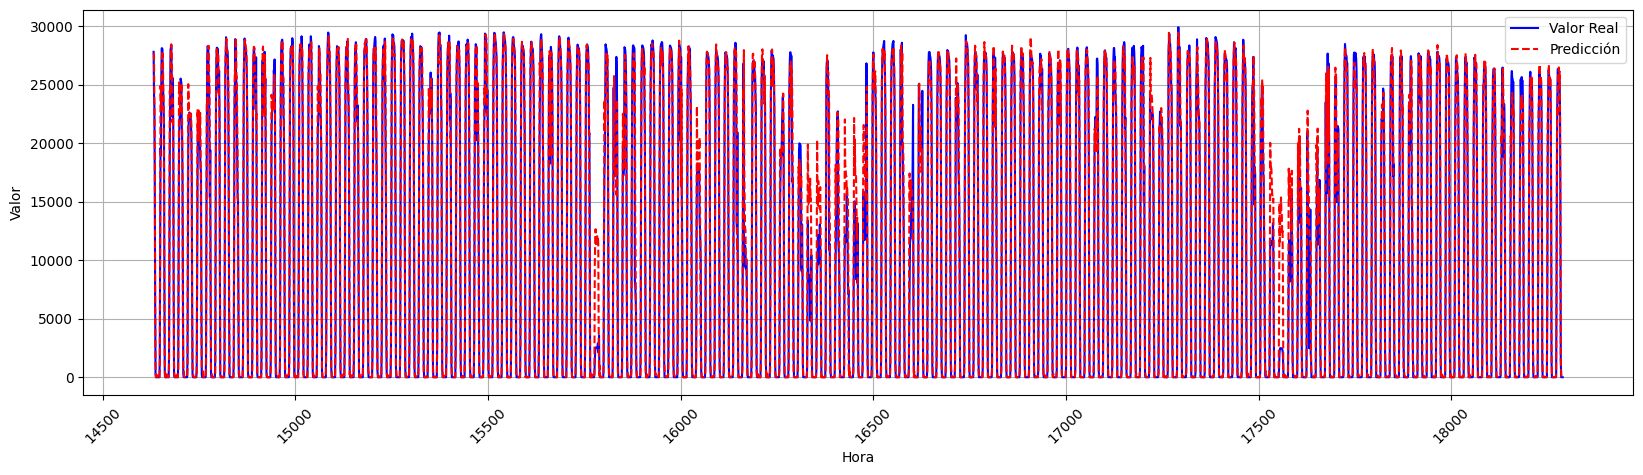

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(resultados['Hora'], resultados['Real'], label='Valor Real', color='blue')
plt.plot(resultados['Hora'], resultados['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

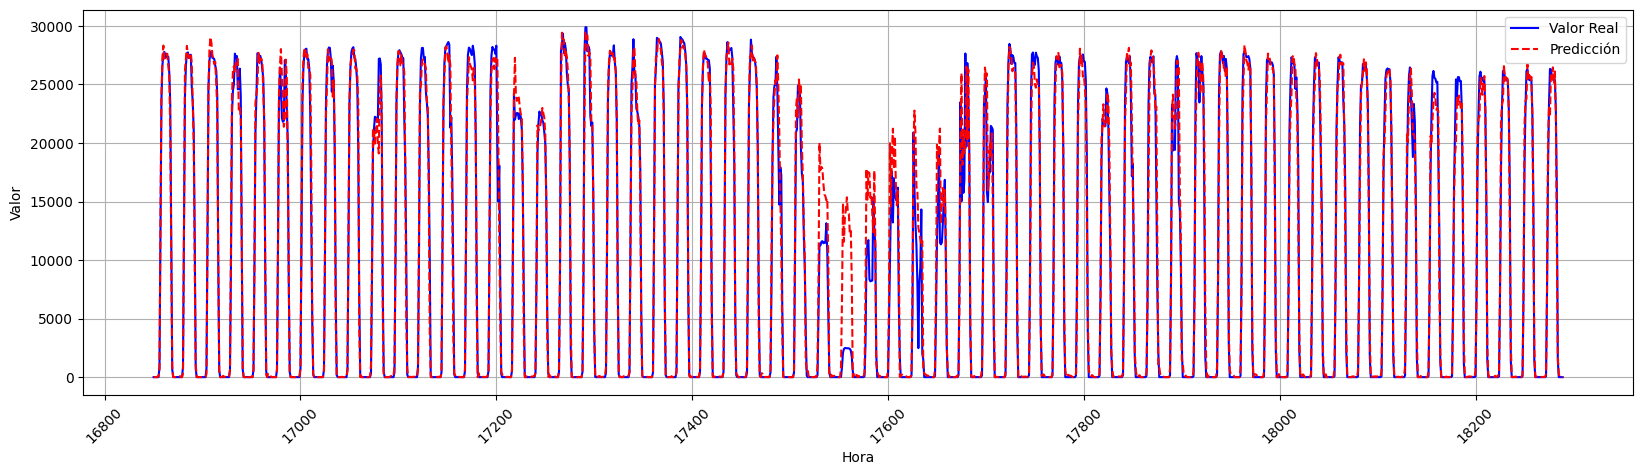

In [30]:
resultados_filtro = resultados.iloc[-(24*60):,:]
plt.figure(figsize=(20, 5))
plt.plot(resultados_filtro['Hora'], resultados_filtro['Real'], label='Valor Real', color='blue')
plt.plot(resultados_filtro['Hora'], resultados_filtro['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

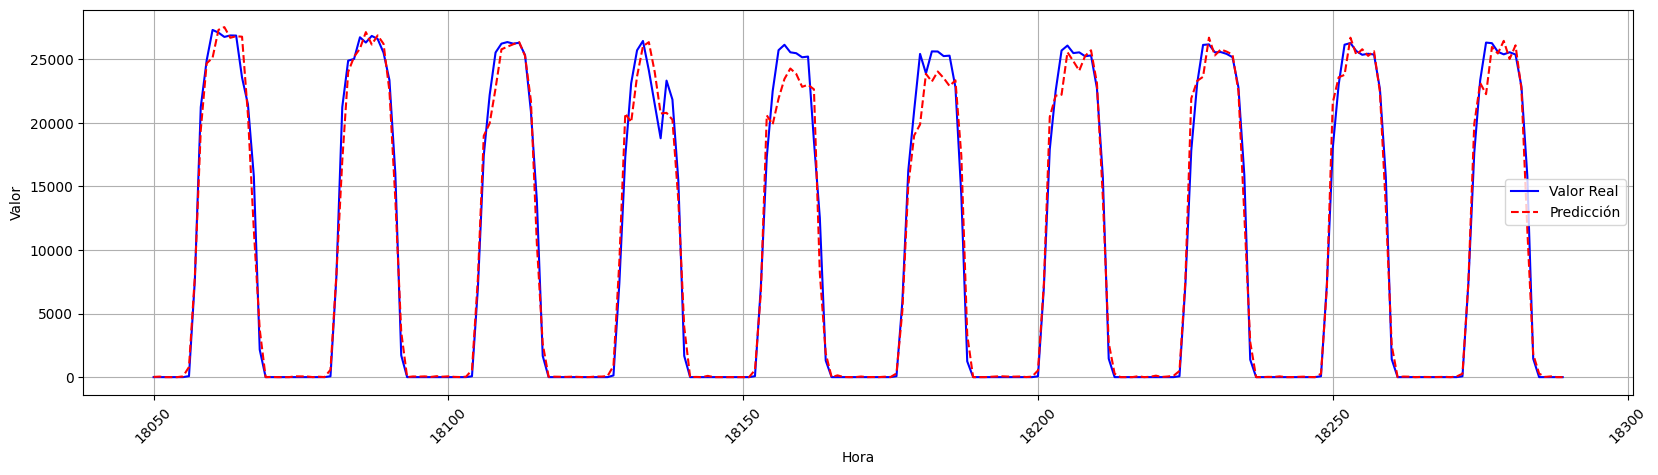

In [31]:
resultados_filtro = resultados.iloc[-(24*10):,:]
plt.figure(figsize=(20, 5))
plt.plot(resultados_filtro['Hora'], resultados_filtro['Real'], label='Valor Real', color='blue')
plt.plot(resultados_filtro['Hora'], resultados_filtro['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()